# Procesamiento Digital de Audio
## Caleb Rascón
### Estimación de Múltiples Direcciones de Arribo
#### MUSIC

In [1]:
# Bibliotecas
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt

### Setup

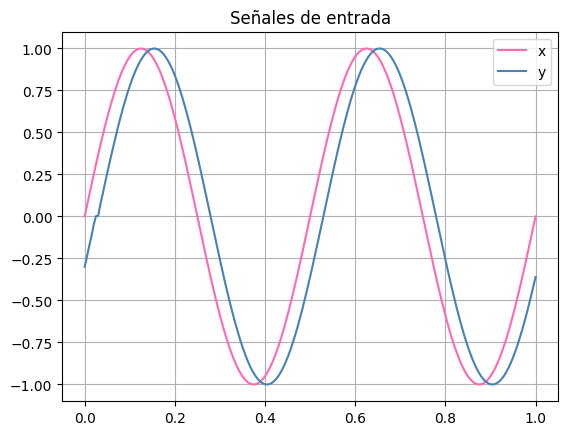

In [2]:
# Direction of arrival of the signal in degrees
doa = 30
# Distance between microphones in meters
d = 20

# Noise presence (between 0 and 1)
noise_w = 0.0

# Signal size in samples, also frequency sampling
K = 200
# Frequency vector
w = np.concatenate( (np.arange(0,K//2 + 1), np.arange(-K//2 + 1, 0)) )

####################

# Base frequency of signal of interest (SOI)
freq = 2
# Speed of sound
c = 343
# Time vecto (1 second)
t = np.arange(K) / (K-1)

# Number of signals in signal sub-space
r = 1
# Number of microphones
N = 2

# Defining the original SOI
s1 = np.sin(2*np.pi*freq*t)

# First mic, steering vector equal to 1, no delay
x = s1

# Second mic, delayed one distance
y = np.real( fft.ifft(fft.fft(s1)* np.exp(-1j*2*np.pi*w*(d/c)*np.sin(doa*np.pi/180))))


# Adding noise
x = x + np.random.randn(K)*noise_w/10
y = y + np.random.randn(K)*noise_w/10

plt.plot(t,x,label='x',color='hotpink')
plt.plot(t,y,label='y',color='steelblue')
plt.title("Señales de entrada")
plt.grid()
plt.legend()
plt.show()


In [3]:
# Data matrix
X = np.array([fft.fft(x), fft.fft(y)])

### MUSIC

In [4]:
# Define angles to look for orthogonality
angles = np.arange(-90,90,.1)
music_spectrum = np.zeros(len(angles))

# Normally, you should do the next step for each appropriate frequency
# We're only doing it in the frequency that most closely fits s1's frequency
this_w = 2 #Since w(2) = 2
this_X = X[:, this_w].reshape(2,1)

#Covariance Matrix
# R = np.outer(this_X, this_X.conj()).T #This matrix should be calculated using past windows, 
# but for now we're using only the current window
R = this_X @ this_X.T.conj()
#Eigendecomposition of covarianve matrix
#Q: vectors
#D: values
D, Q = np.linalg.eig(R)

#Sorting eigenvalues (descending order)
sort_index = np.argsort(-D)

#Sorting eigenvectors
Q = Q[:,sort_index]

#Getting signal eigenvectors
Qs = Q[:,:r]

#Getting noise eigenvectors
Qn = Q[:,r:N]

#Compute steering vectors corresponding to values in angles
a1 = np.zeros((N, len(angles)))
a1[0,:] = np.ones(len(angles)) #First microphones is refrence, no delay
a1[1,:] = np.exp( -1j*2*np.pi*w[this_w] * (d/c) * np.sin(angles*np.pi/180) )

/tmp/ipykernel_21698/3658412050.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  a1[1,:] = np.exp( -1j*2*np.pi*w[this_w] * (d/c) * np.sin(angles*np.pi/180) )


In [5]:
#Compute MUSIC spectrum
for k in range(len(angles)):
  music_spectrum[k] = abs( 1/(a1[:,k].T @ Qn @ Qn.T @ a1[:,k]) )


In [6]:
angles[np.argmax(music_spectrum)]

-30.00000000000341

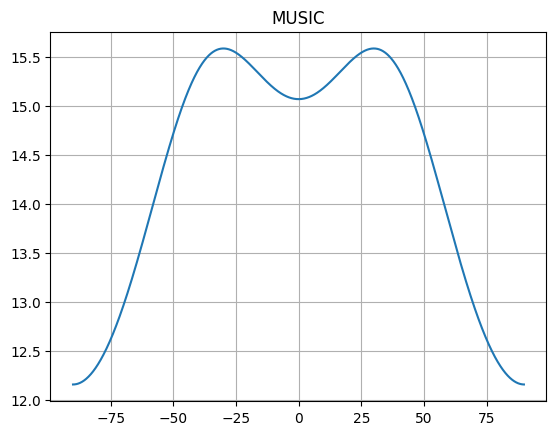

In [7]:
plt.plot(angles, music_spectrum)
plt.title('MUSIC')
plt.grid()
plt.show()